![dvd_image](/content/dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Import any additional modules and start coding below

In [ ]:
!pip install catboost

# Import the dataset

In [3]:
rental_df = pd.read_csv('rental_info.csv')
rental_df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [4]:
rental_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


# Explore the dataset

In [5]:
for col in rental_df.columns:
    print(rental_df[col].value_counts())

rental_date
2005-06-20 14:10:29+00:00    2
2005-08-02 00:22:51+00:00    2
2005-08-18 04:10:04+00:00    2
2005-07-29 04:14:37+00:00    2
2005-08-01 04:08:01+00:00    2
                            ..
2005-05-27 04:09:24+00:00    1
2005-06-21 09:18:27+00:00    1
2005-07-11 17:13:45+00:00    1
2005-07-31 10:03:17+00:00    1
2005-08-18 06:33:55+00:00    1
Name: count, Length: 15813, dtype: int64
return_date
2005-08-29 00:49:42+00:00    2
2005-08-24 03:33:05+00:00    2
2005-07-14 08:00:23+00:00    2
2005-06-05 19:16:54+00:00    2
2005-06-22 01:54:15+00:00    2
                            ..
2005-08-05 21:56:53+00:00    1
2005-08-21 13:31:45+00:00    1
2005-08-02 22:40:06+00:00    1
2005-08-26 18:56:43+00:00    1
2005-08-24 07:14:55+00:00    1
Name: count, Length: 15836, dtype: int64
amount
4.99     3748
2.99     3501
0.99     2924
5.99     1299
6.99     1119
3.99     1107
7.99      670
1.99      638
8.99      485
9.99      256
10.99     104
11.99      10
Name: count, dtype: int64
release_yea

## Adding `rental_length_days` from `return_date` and `rental_date`

In [6]:
rental_df['rental_date'] = pd.to_datetime(rental_df['rental_date'])
rental_df['return_date'] = pd.to_datetime(rental_df['return_date'])

In [7]:
rental_df['rental_length_days'] = (rental_df['return_date']-rental_df['rental_date']).dt.days
rental_df['rental_length_days']

,rental_length_days
0,3
1,2
2,7
3,2
4,4
...,...
15856,6
15857,4
15858,9
15859,8


## Adding the dummy variables from `special_features`

In [8]:
# First let's extract the elements from the special_features column

rental_df['special_features'] = rental_df['special_features'].apply(lambda x : [element.strip('"') for element in x.strip('{}').split(',')])

rental_df['special_features']

,special_features
0,"[Trailers, Behind the Scenes]"
1,"[Trailers, Behind the Scenes]"
2,"[Trailers, Behind the Scenes]"
3,"[Trailers, Behind the Scenes]"
4,"[Trailers, Behind the Scenes]"
...,...
15856,"[Trailers, Deleted Scenes, Behind the Scenes]"
15857,"[Trailers, Deleted Scenes, Behind the Scenes]"
15858,"[Trailers, Deleted Scenes, Behind the Scenes]"
15859,"[Trailers, Deleted Scenes, Behind the Scenes]"


In [9]:
# Creating "deleted_scenes" and "behind_the_scenes" features

rental_df['deleted_scenes'] = rental_df['special_features'].apply(lambda x : 1 if "Deleted Scenes" in x else 0)
rental_df['behind_the_scenes'] = rental_df['special_features'].apply(lambda x : 1 if "Behind the Scenes" in x else 0)
rental_df['trailers'] = rental_df['special_features'].apply(lambda x : 1 if "Trailers" in x else 0)
rental_df['commentaries'] = rental_df['special_features'].apply(lambda x : 1 if "Commentaries" in x else 0)

In [10]:
rental_df.tail(20)

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes,trailers,commentaries
15841,2005-07-29 11:45:00+00:00,2005-08-05 13:46:00+00:00,5.99,2005.0,2.99,90.0,17.99,"[Commentaries, Behind the Scenes]",0,0,0,1,35.8801,8100.0,8.9401,7,0,1,0,1
15842,2005-08-23 19:38:34+00:00,2005-08-25 14:06:34+00:00,2.99,2005.0,2.99,90.0,17.99,"[Commentaries, Behind the Scenes]",0,0,0,1,8.9401,8100.0,8.9401,1,0,1,0,1
15843,2005-07-29 22:34:33+00:00,2005-08-02 20:05:33+00:00,2.99,2005.0,2.99,90.0,17.99,"[Commentaries, Behind the Scenes]",0,0,0,1,8.9401,8100.0,8.9401,3,0,1,0,1
15844,2005-08-23 06:26:10+00:00,2005-08-30 05:07:10+00:00,5.99,2005.0,2.99,90.0,17.99,"[Commentaries, Behind the Scenes]",0,0,0,1,35.8801,8100.0,8.9401,6,0,1,0,1
15845,2005-08-02 12:20:31+00:00,2005-08-04 09:06:31+00:00,2.99,2005.0,2.99,90.0,17.99,"[Commentaries, Behind the Scenes]",0,0,0,1,8.9401,8100.0,8.9401,1,0,1,0,1
15846,2005-08-17 13:55:28+00:00,2005-08-19 19:53:28+00:00,2.99,2005.0,2.99,90.0,17.99,"[Commentaries, Behind the Scenes]",0,0,0,1,8.9401,8100.0,8.9401,2,0,1,0,1
15847,2005-07-28 21:02:32+00:00,2005-08-01 02:05:32+00:00,4.99,2004.0,4.99,71.0,26.99,"[Trailers, Deleted Scenes]",0,0,0,1,24.9001,5041.0,24.9001,3,1,0,1,0
15848,2005-08-22 05:27:51+00:00,2005-08-23 07:24:51+00:00,4.99,2004.0,4.99,71.0,26.99,"[Trailers, Deleted Scenes]",0,0,0,1,24.9001,5041.0,24.9001,1,1,0,1,0
15849,2005-08-03 02:18:24+00:00,2005-08-05 01:22:24+00:00,4.99,2004.0,4.99,71.0,26.99,"[Trailers, Deleted Scenes]",0,0,0,1,24.9001,5041.0,24.9001,1,1,0,1,0
15850,2005-08-24 01:56:04+00:00,2005-08-31 05:24:04+00:00,9.99,2004.0,4.99,71.0,26.99,"[Trailers, Deleted Scenes]",0,0,0,1,99.8001,5041.0,24.9001,7,1,0,1,0


## Dropping all unneeded columns

In [11]:
rental_df.drop(['rental_date','return_date','special_features'],axis=1,inplace=True)

## Is there any NaN values in the dataset ??

In [12]:
rental_df.isna().sum()

,0
amount,0
release_year,0
rental_rate,0
length,0
replacement_cost,0
NC-17,0
PG,0
PG-13,0
R,0
amount_2,0


## Making some visualization between the features and the target column

In [13]:
features = rental_df.columns.drop('rental_length_days')
target = 'rental_length_days'
numerical_features = ['amount', 'rental_rate', 'length', 'replacement_cost', 'amount_2', 'length_2', 'rental_rate_2','release_year']
categorical_features = [col for col in features if col not in numerical_features]
numerical_features, categorical_features

(['amount',
  'rental_rate',
  'length',
  'replacement_cost',
  'amount_2',
  'length_2',
  'rental_rate_2',
  'release_year'],
 ['NC-17',
  'PG',
  'PG-13',
  'R',
  'deleted_scenes',
  'behind_the_scenes',
  'trailers',
  'commentaries'])

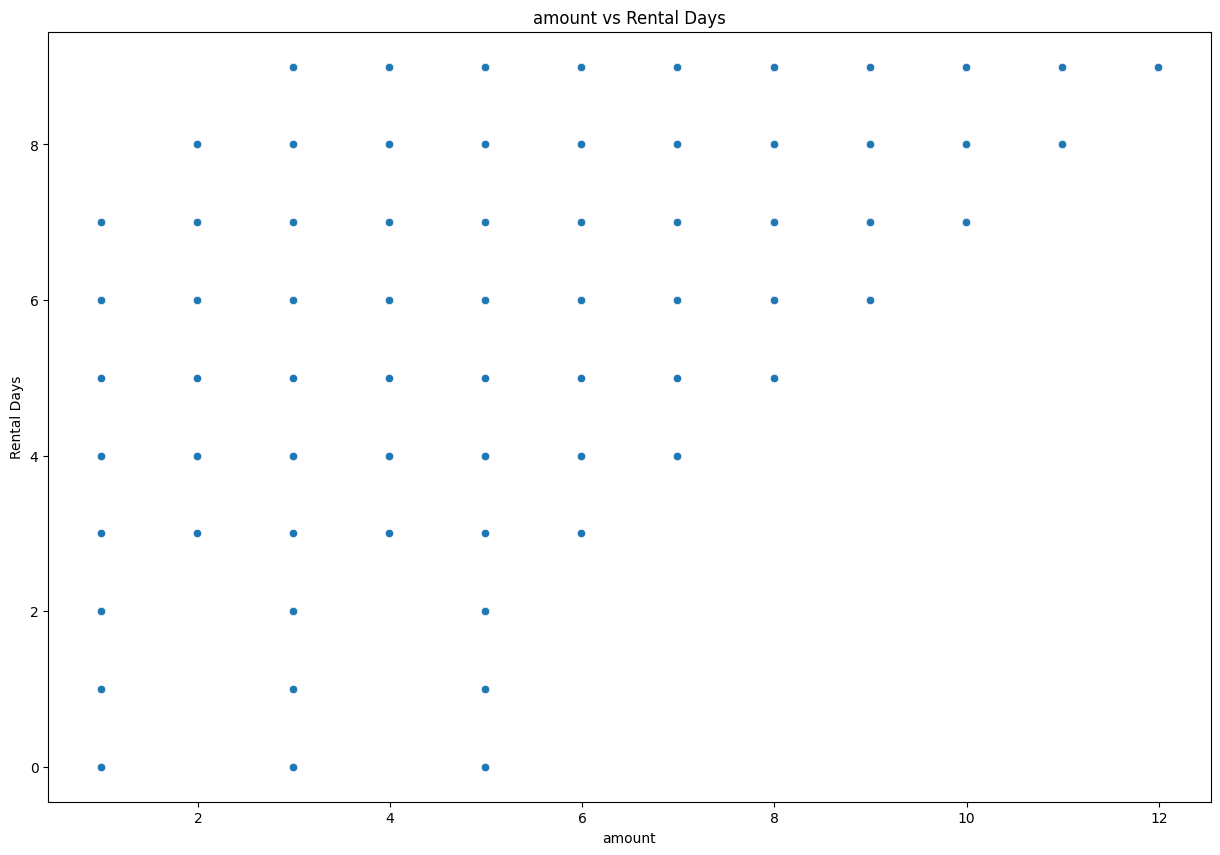

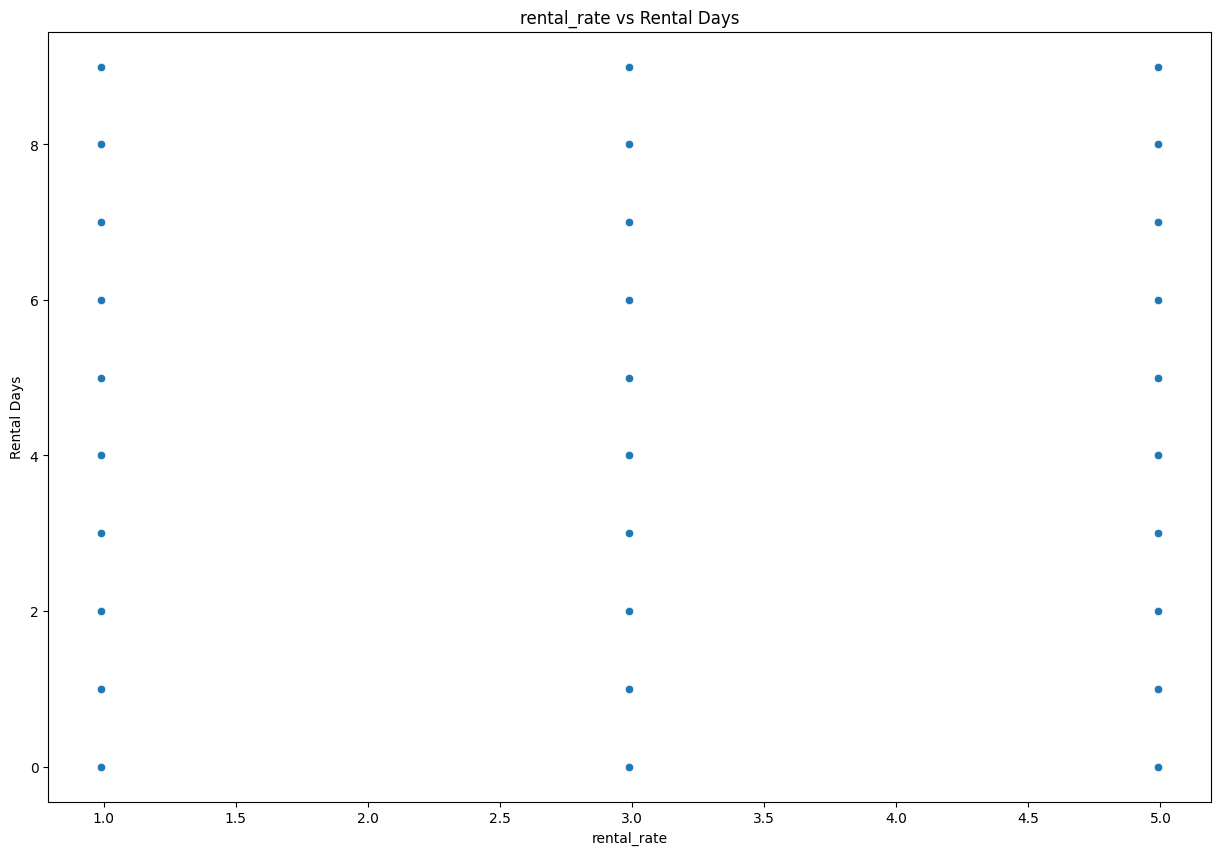

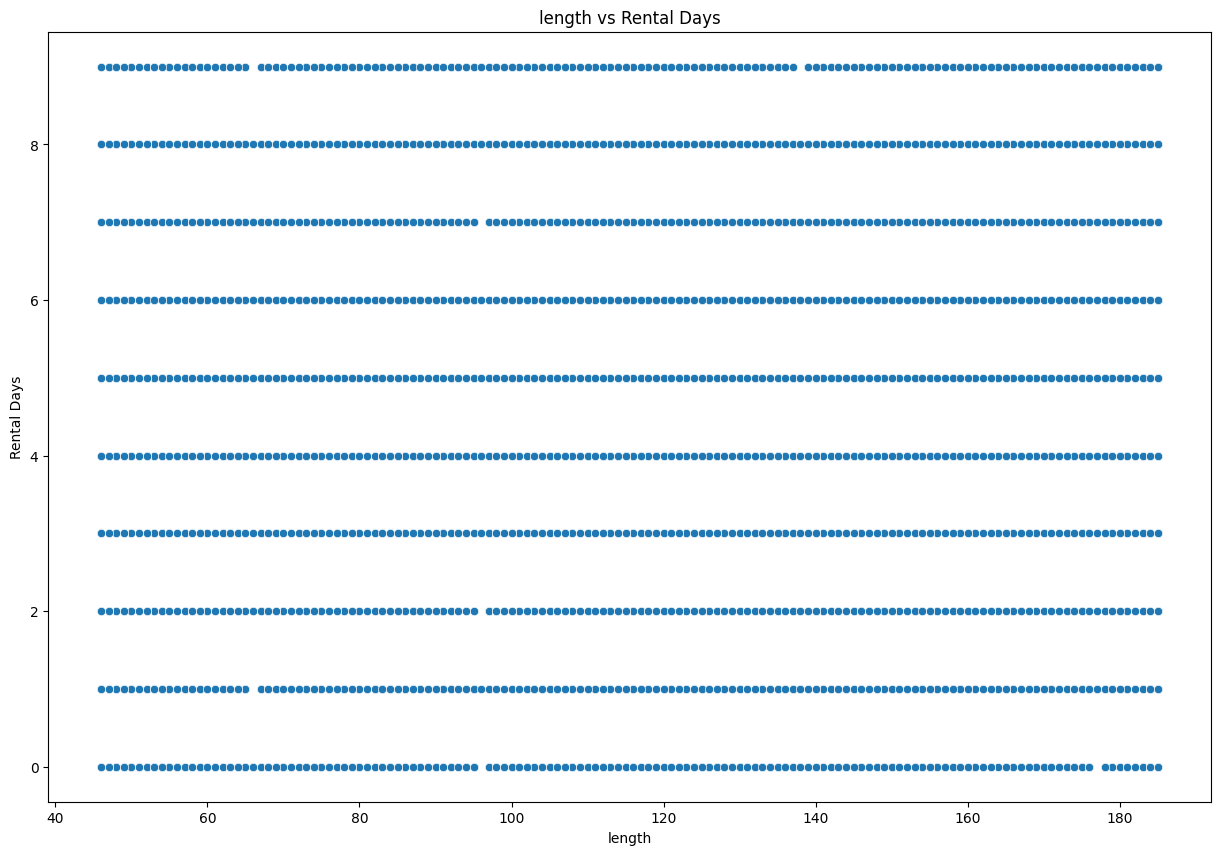

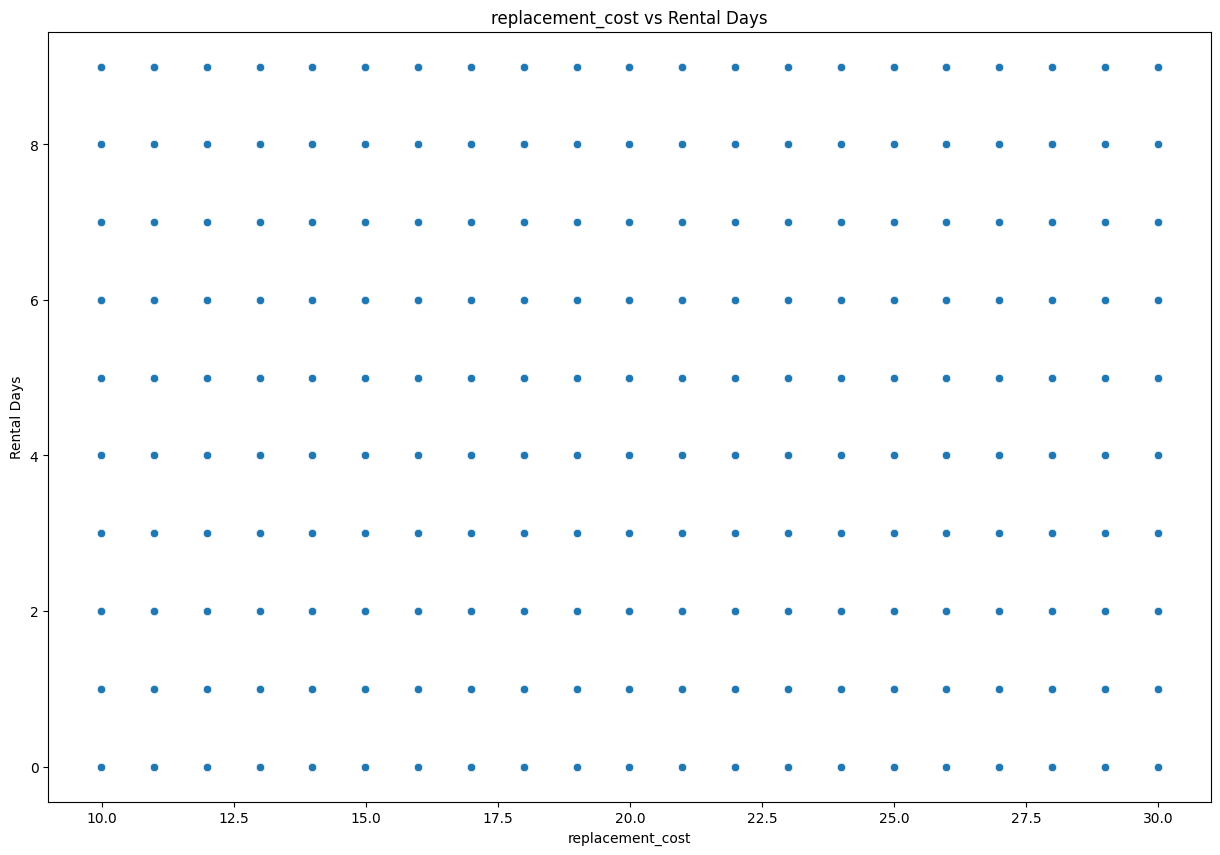

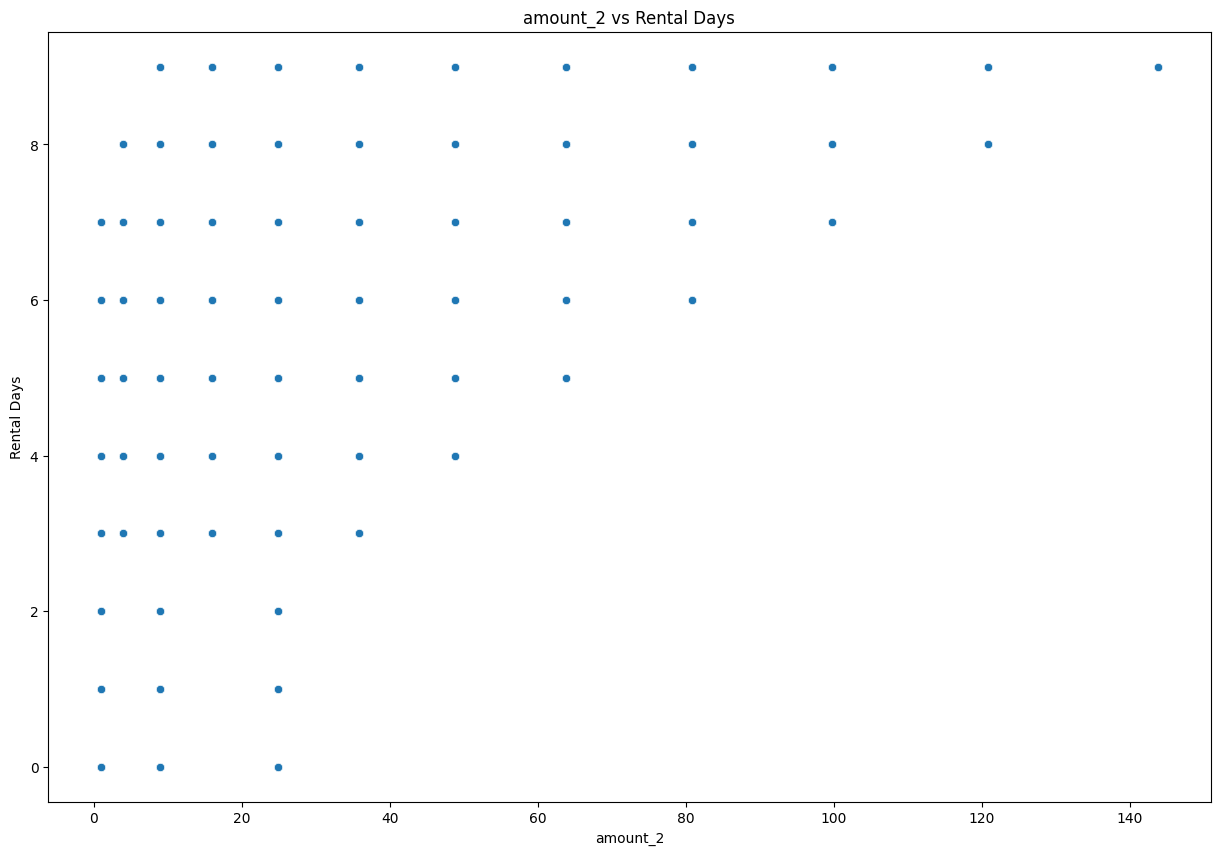

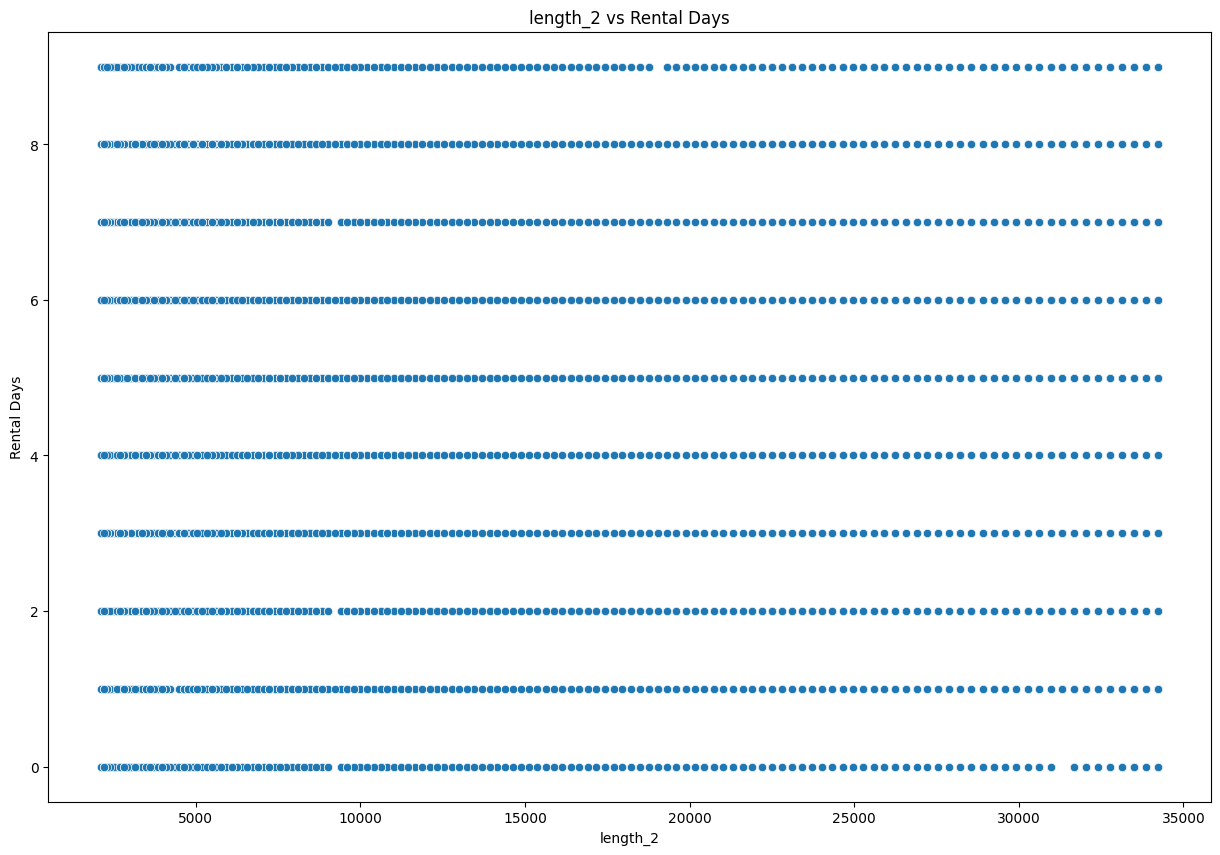

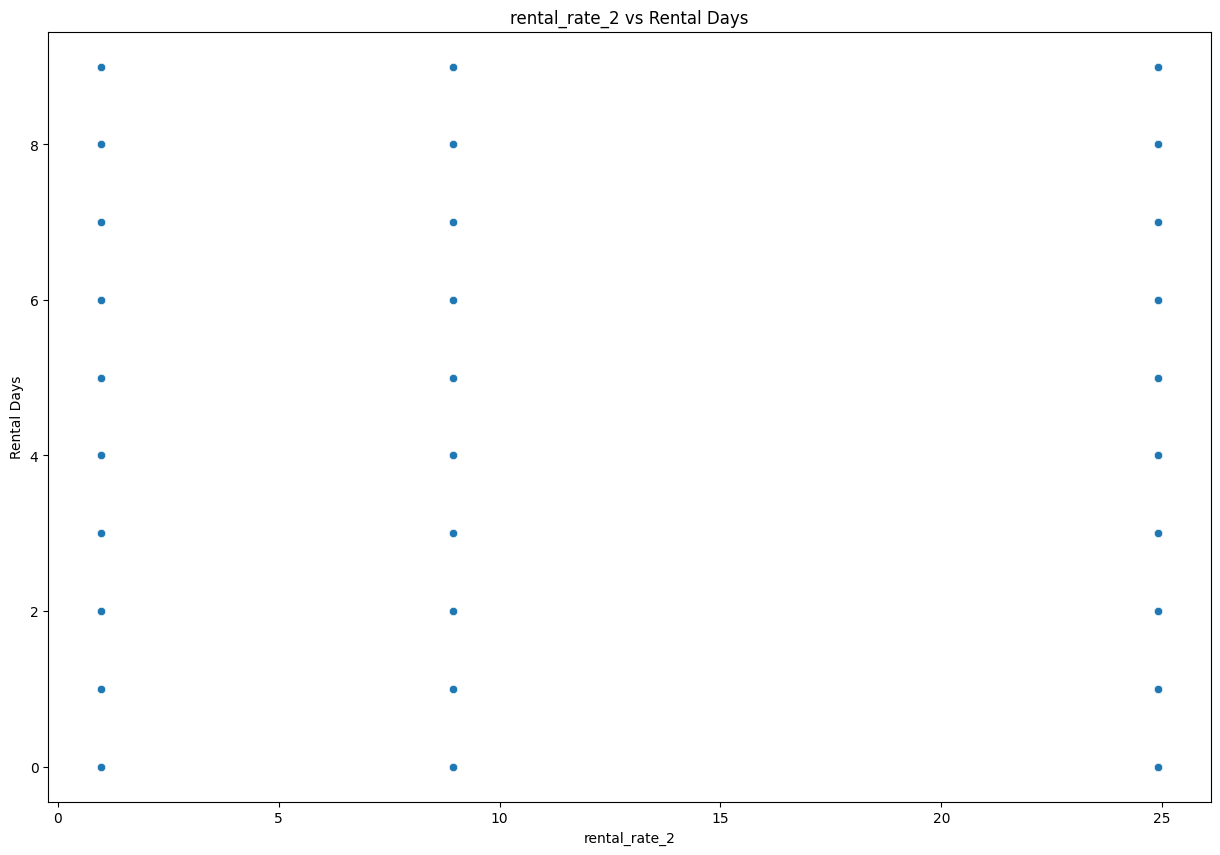

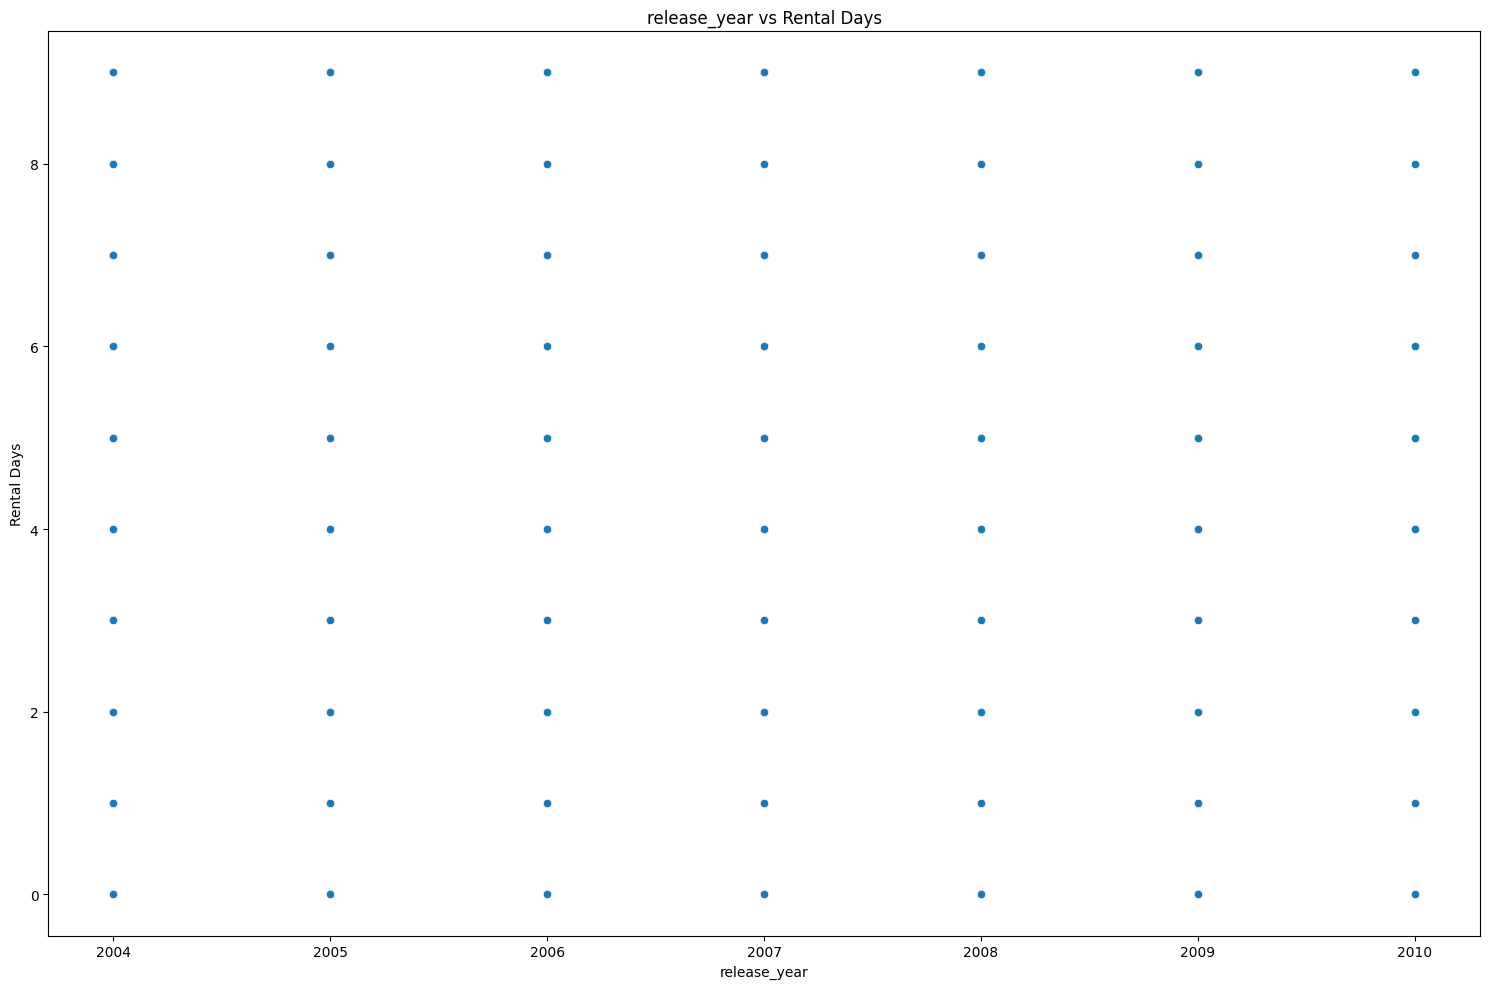

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

for i, feature in enumerate(numerical_features, 1):
    plt.figure(figsize=(15, 10))
    sns.scatterplot(x=rental_df[feature], y=rental_df[target])
    plt.title(f'{feature} vs Rental Days')
    plt.xlabel(feature)
    plt.ylabel('Rental Days')
plt.tight_layout()
plt.show()

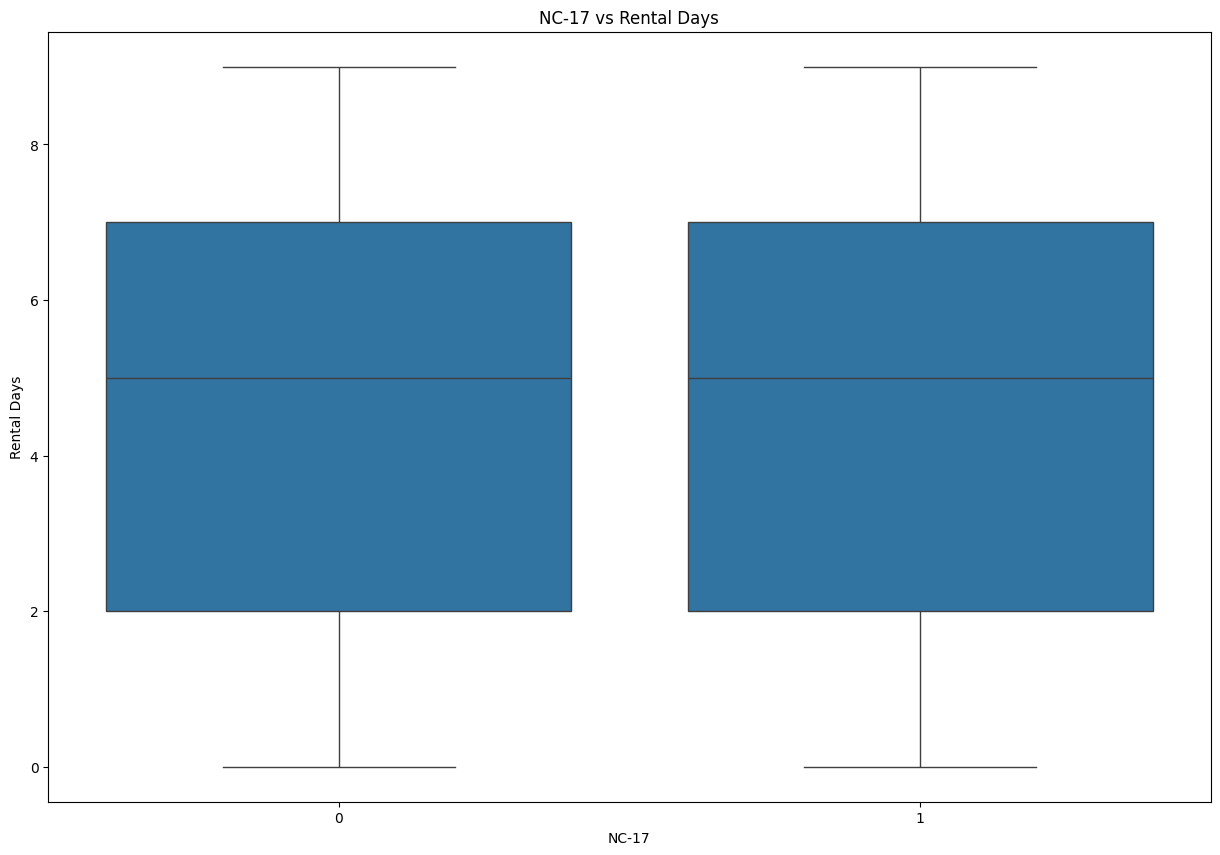

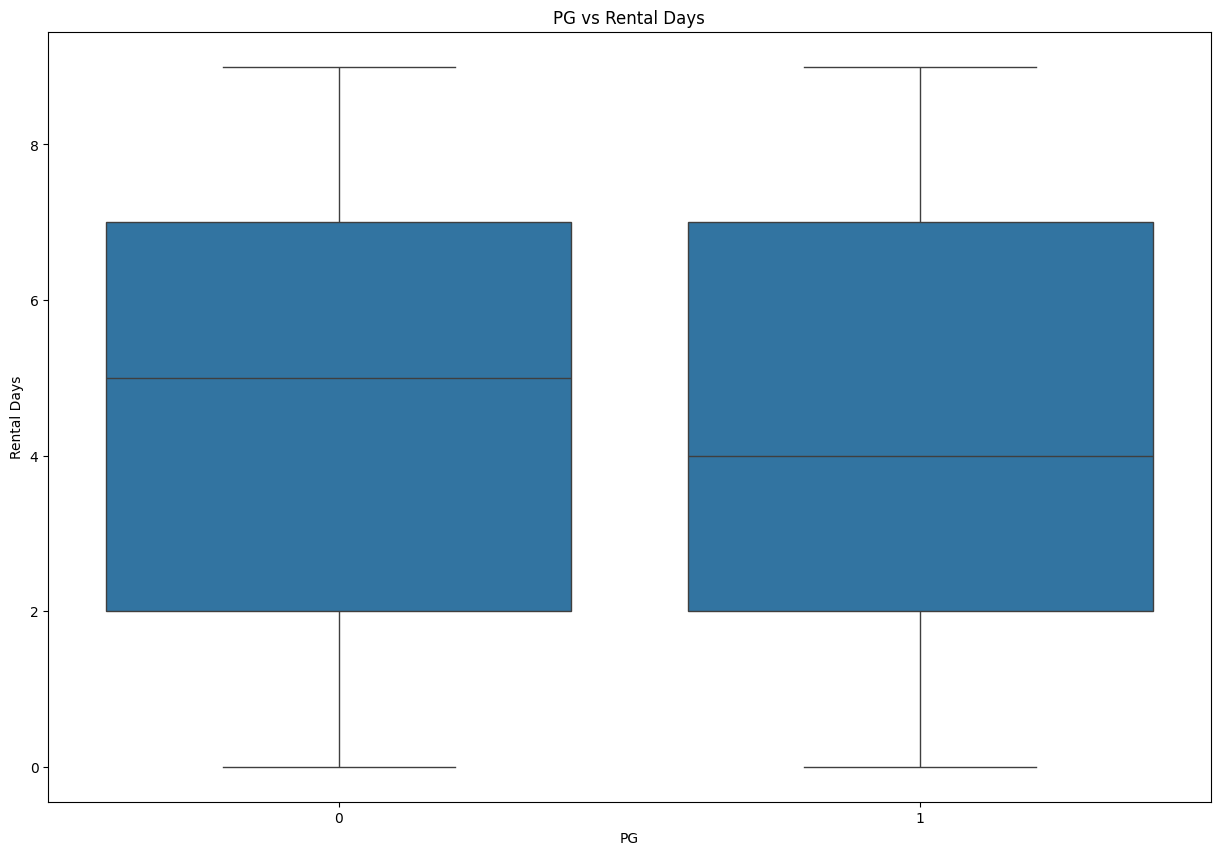

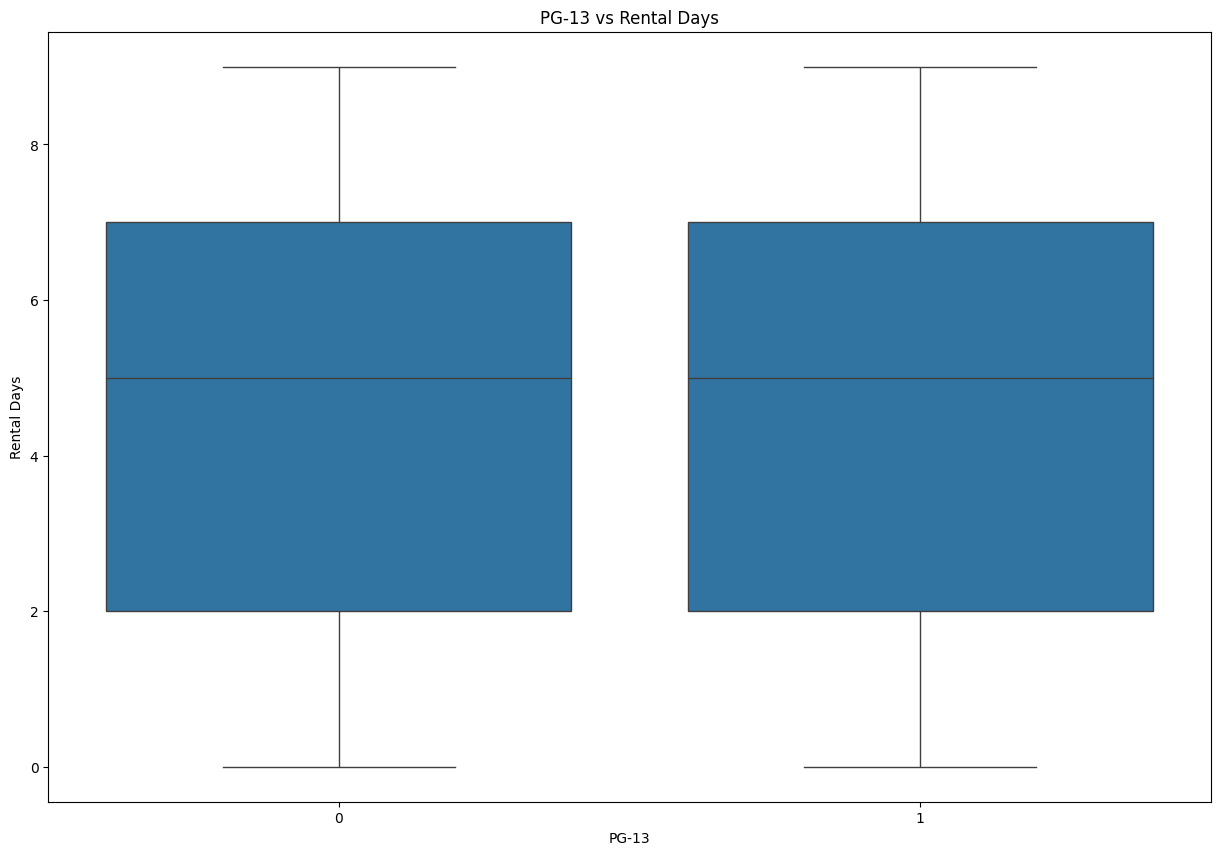

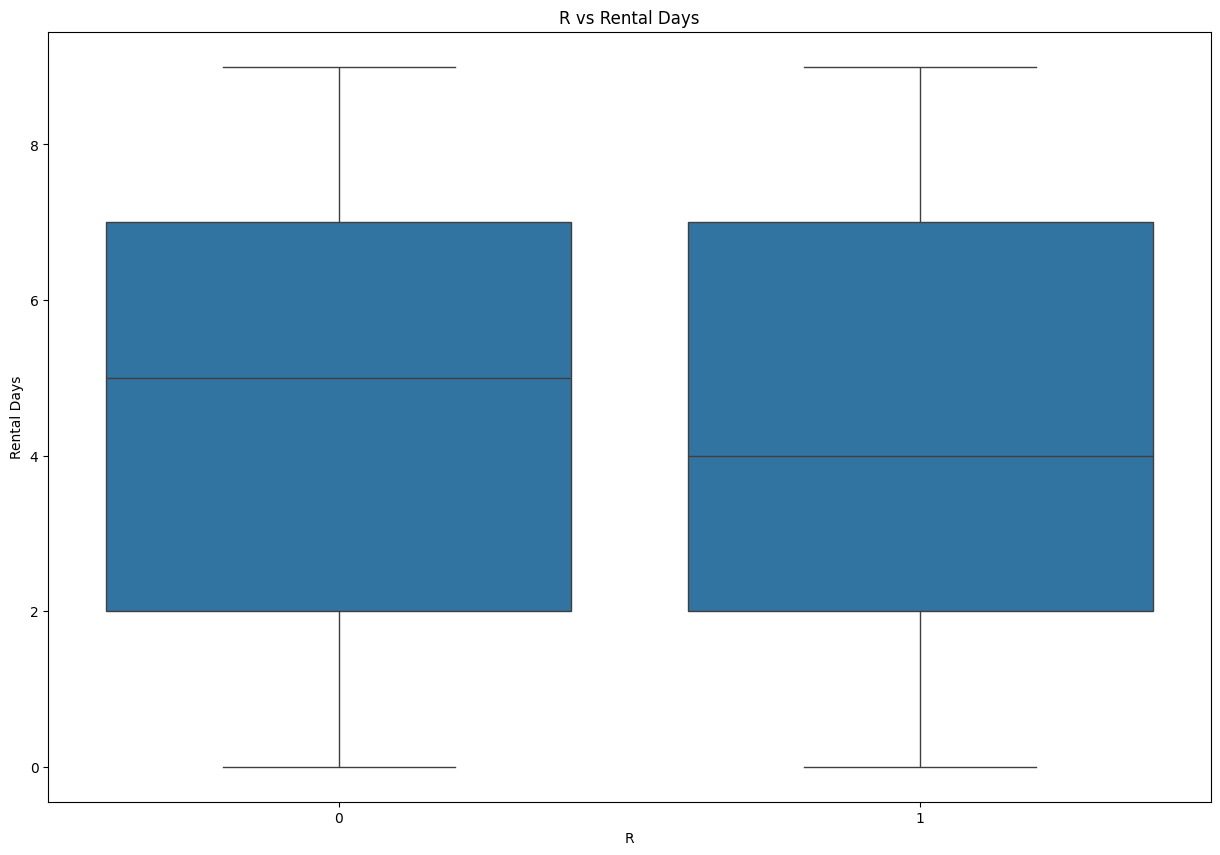

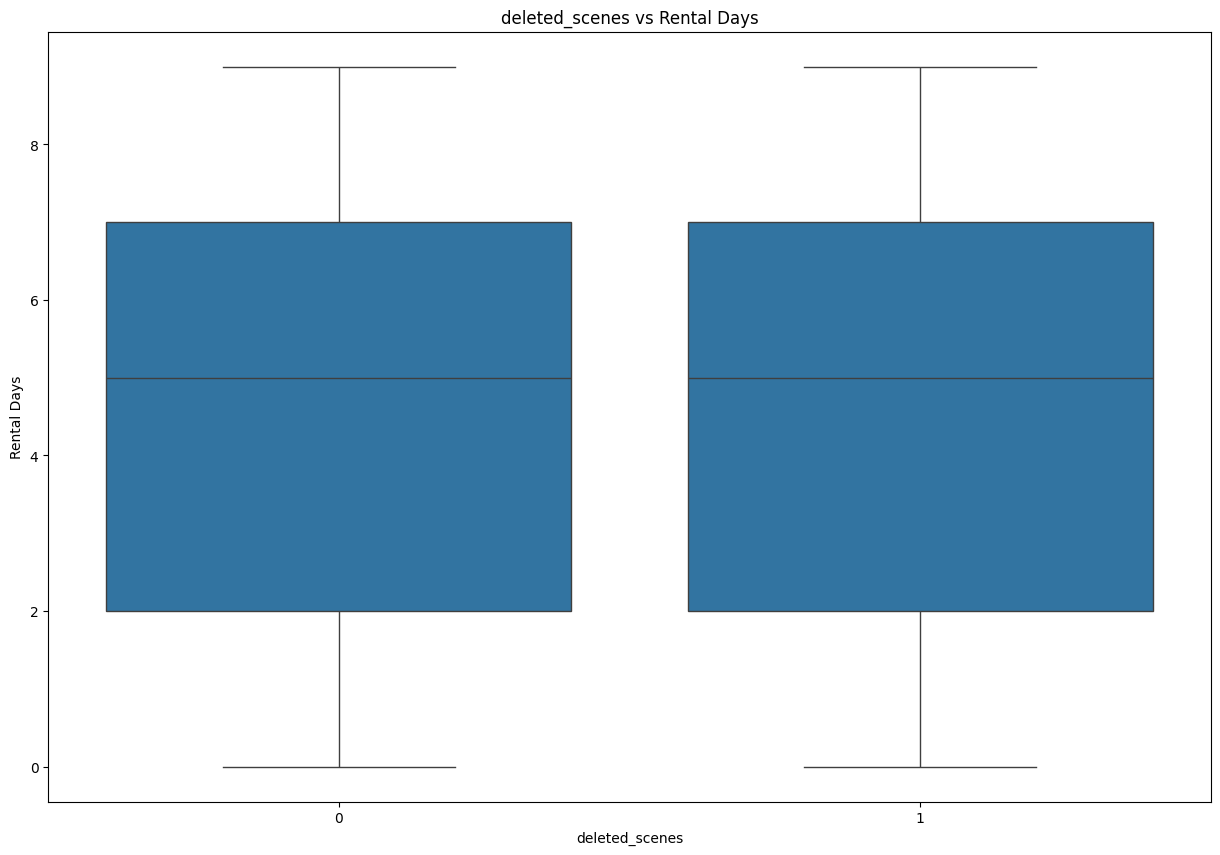

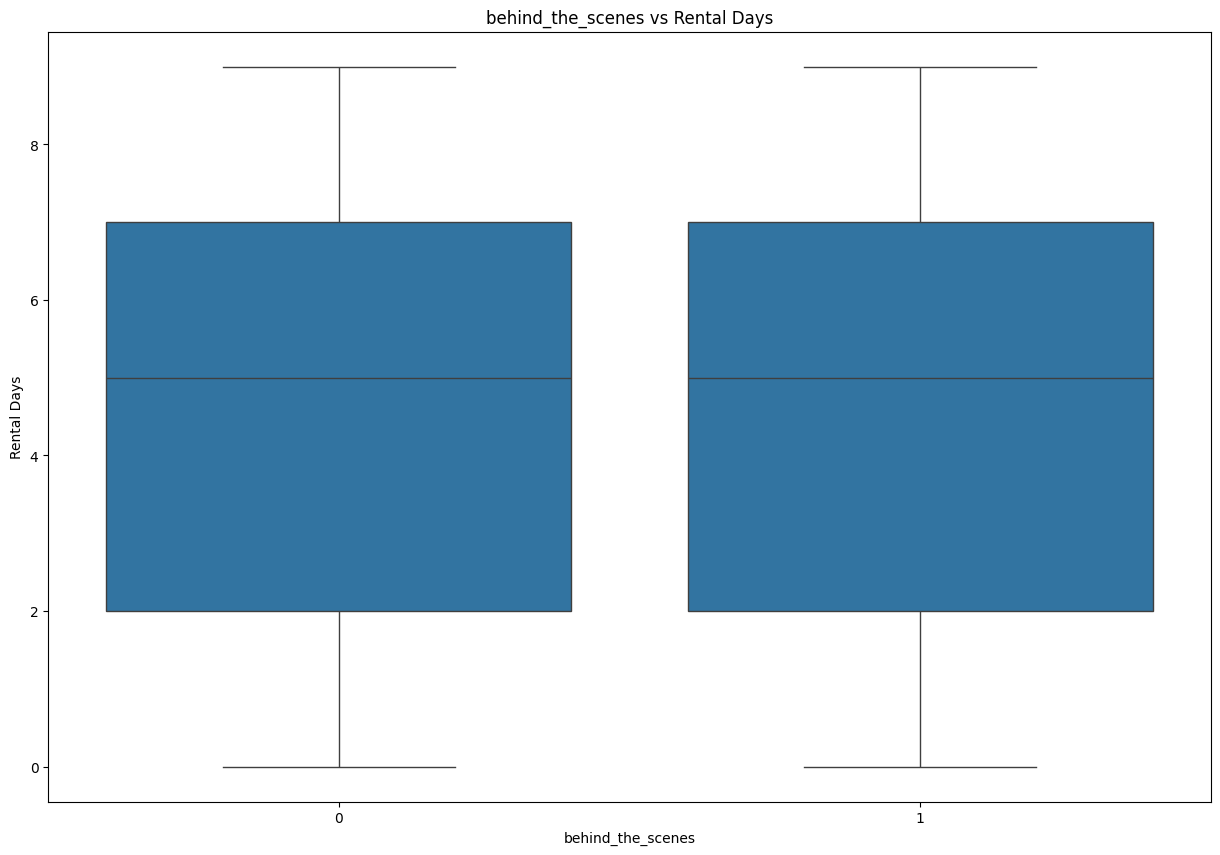

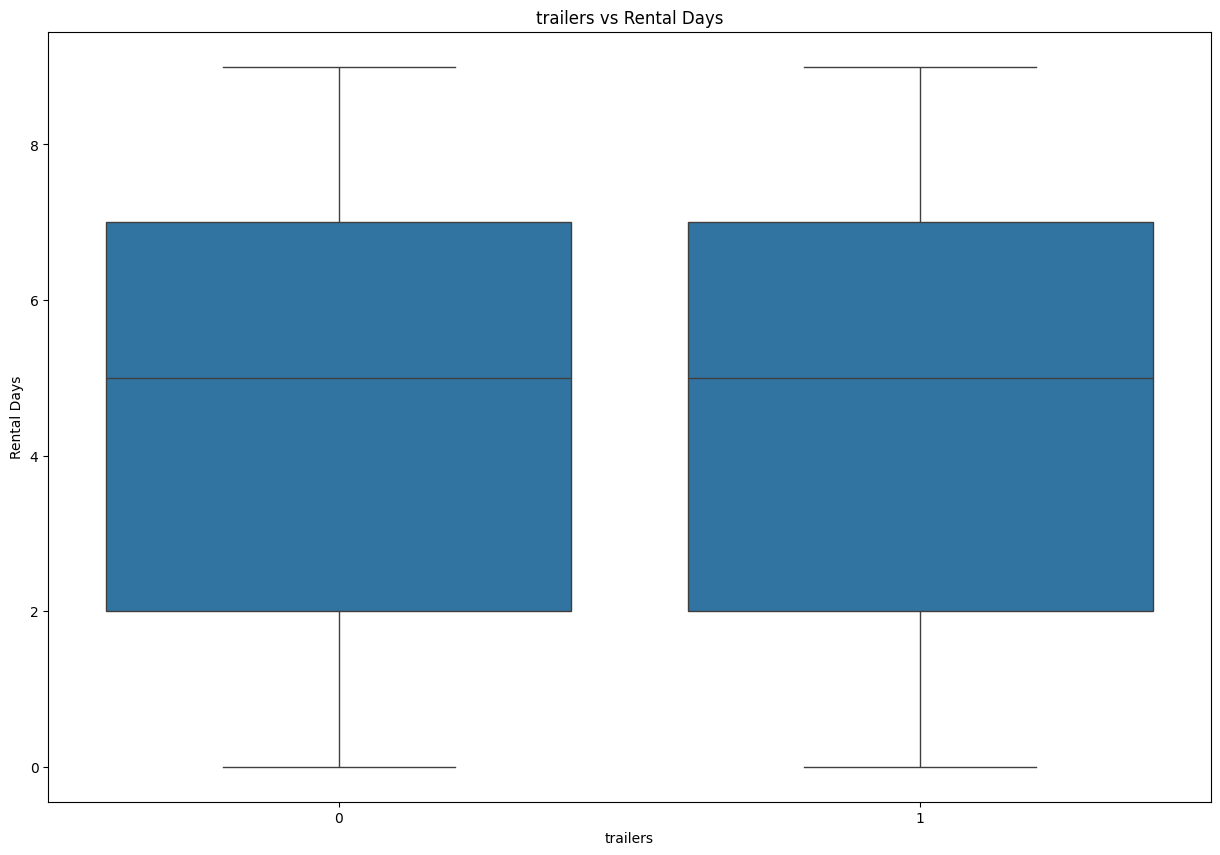

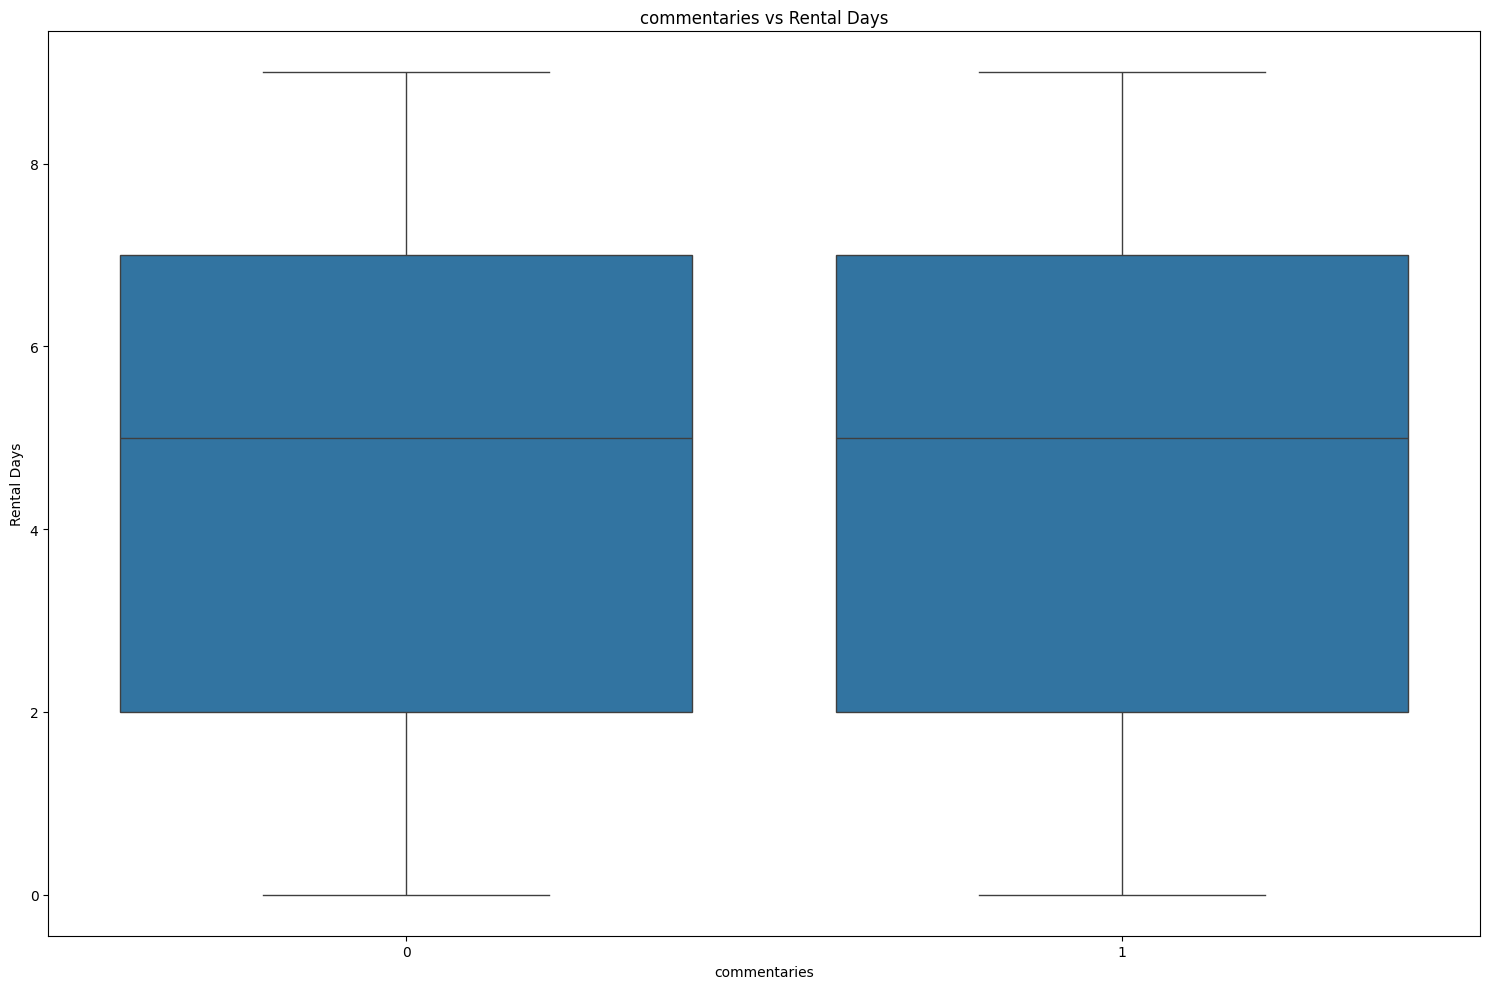

In [15]:
for i,col in enumerate(categorical_features,1):
    plt.figure(figsize=(15,10))
    sns.boxplot(x=col, y=target, data=rental_df)
    plt.title(f'{col} vs Rental Days')
    plt.xlabel(col)
    plt.ylabel('Rental Days')
plt.tight_layout()
plt.show()

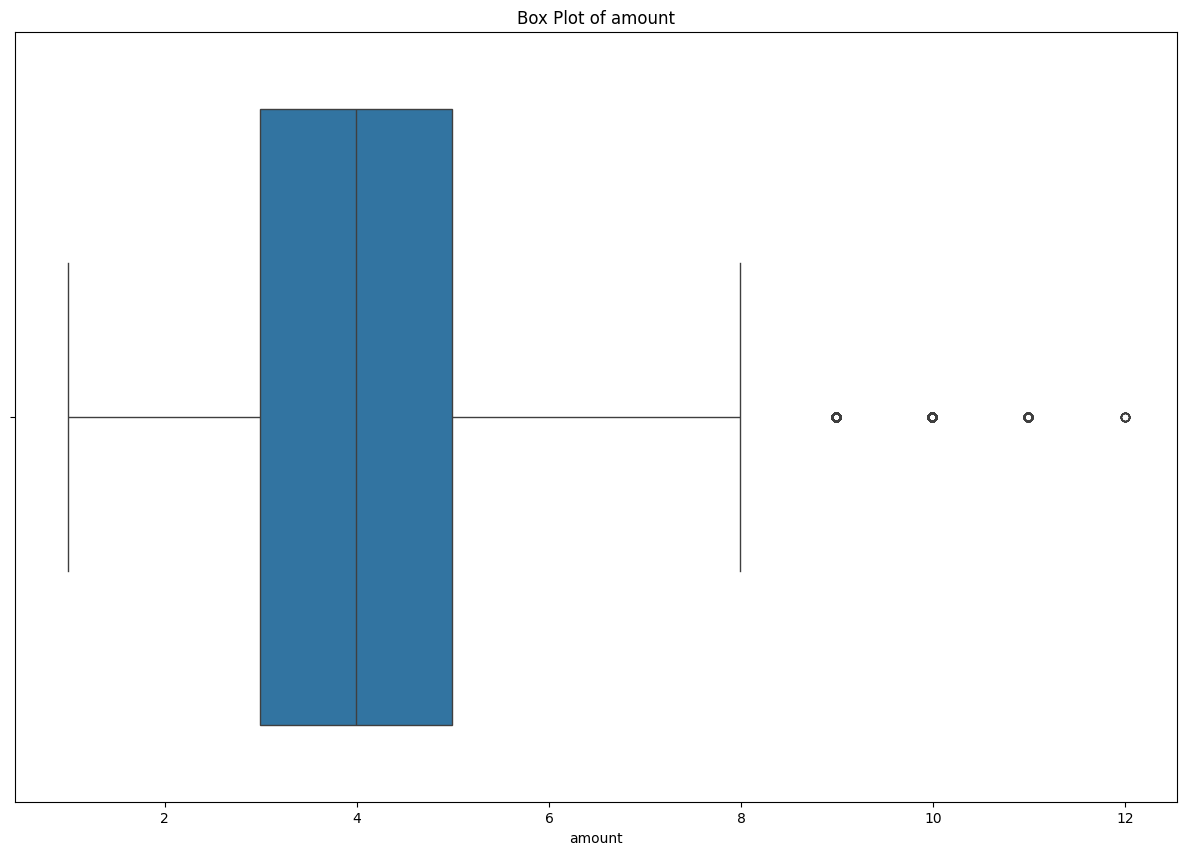

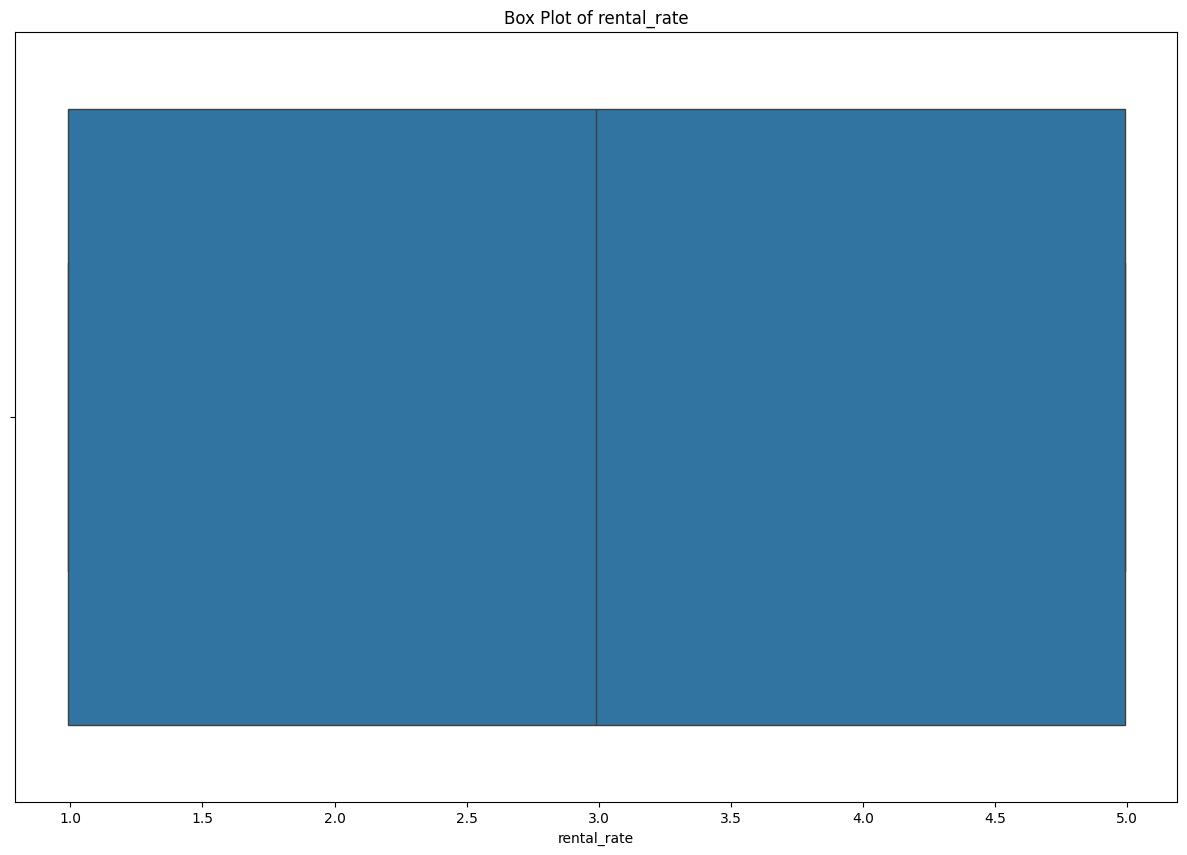

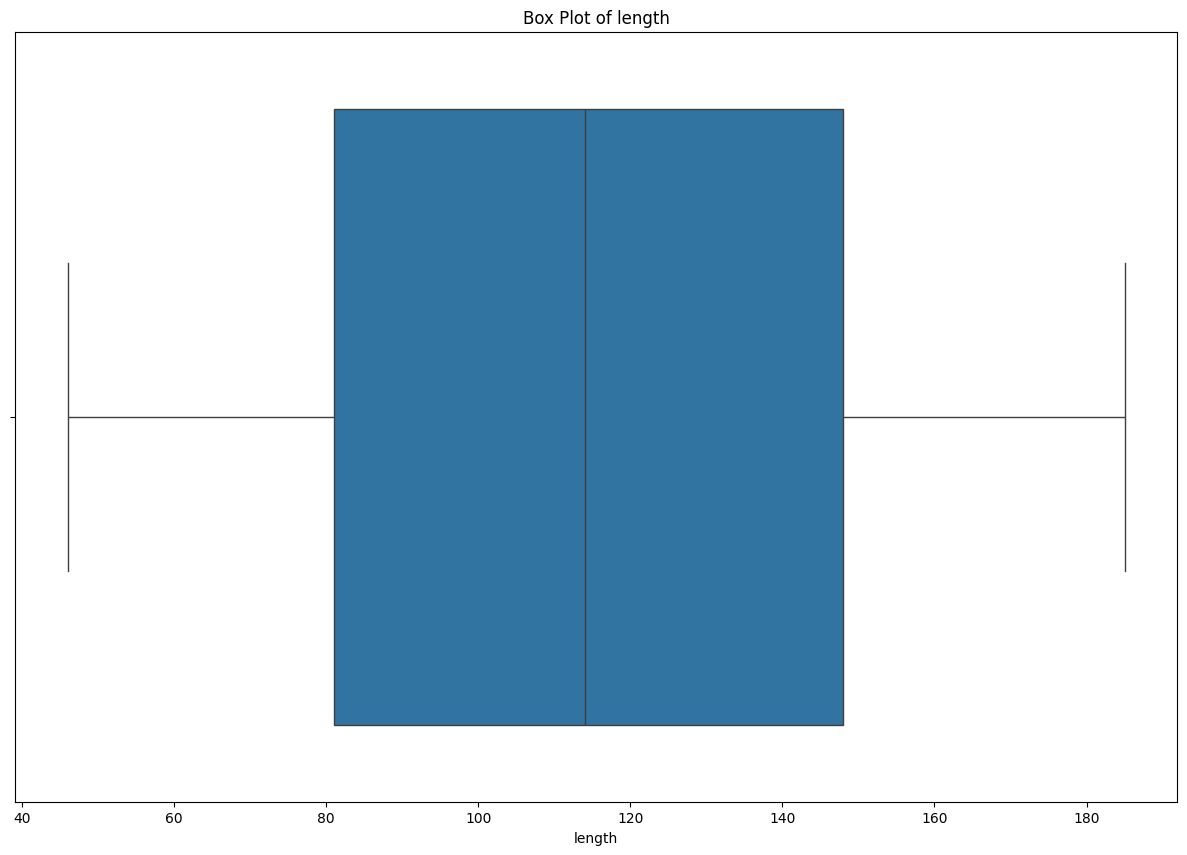

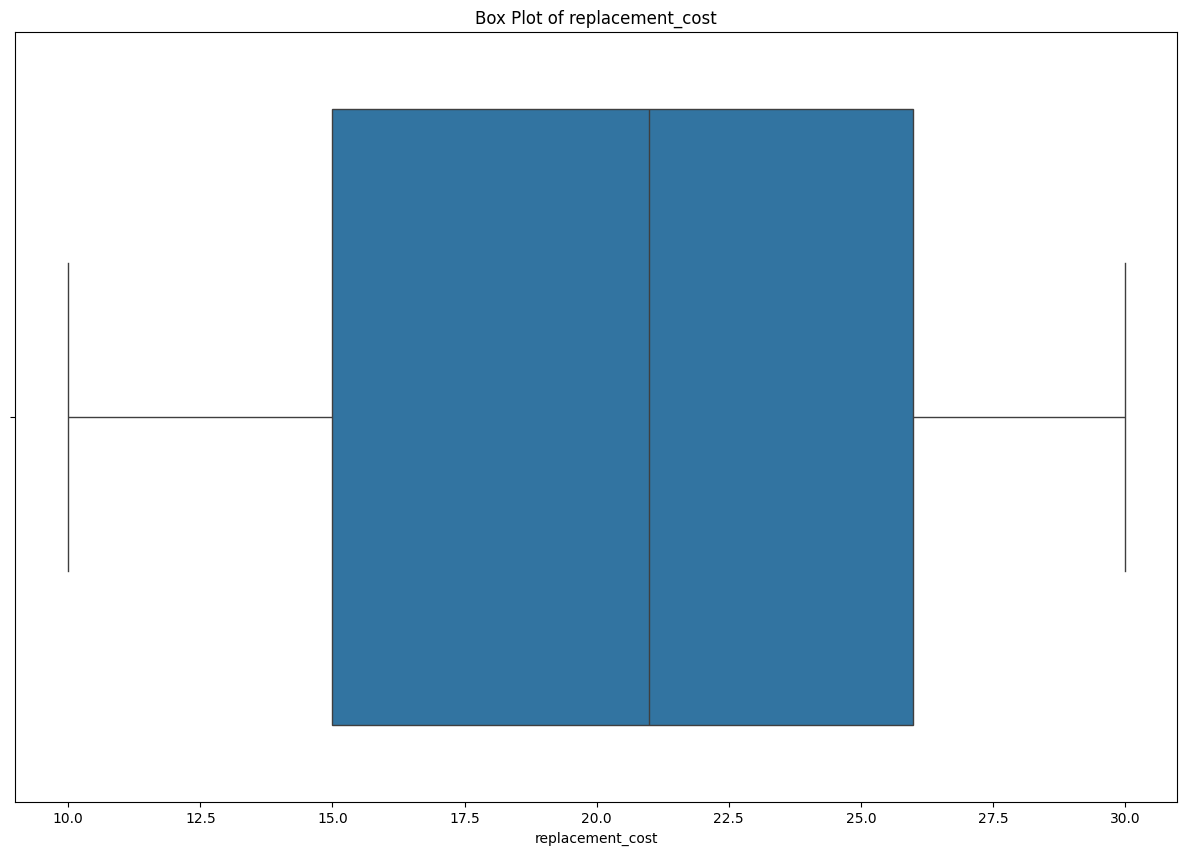

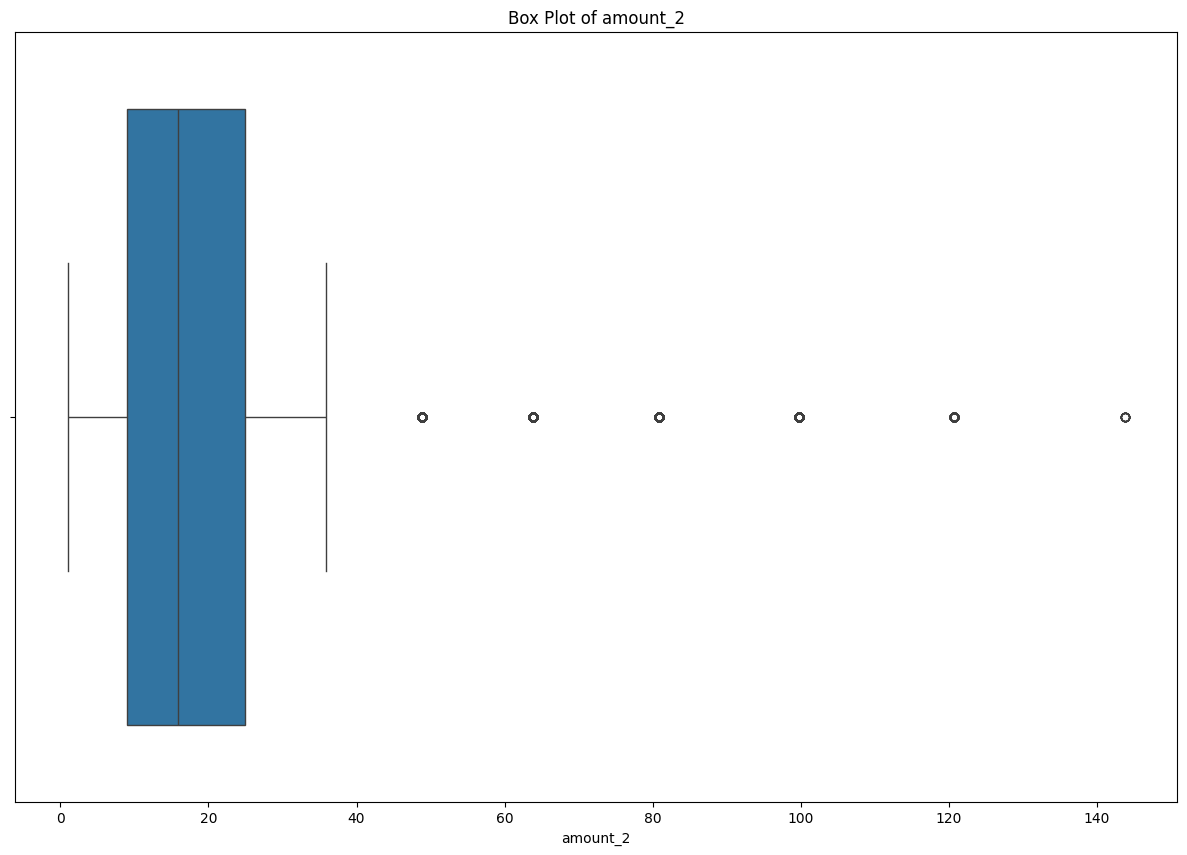

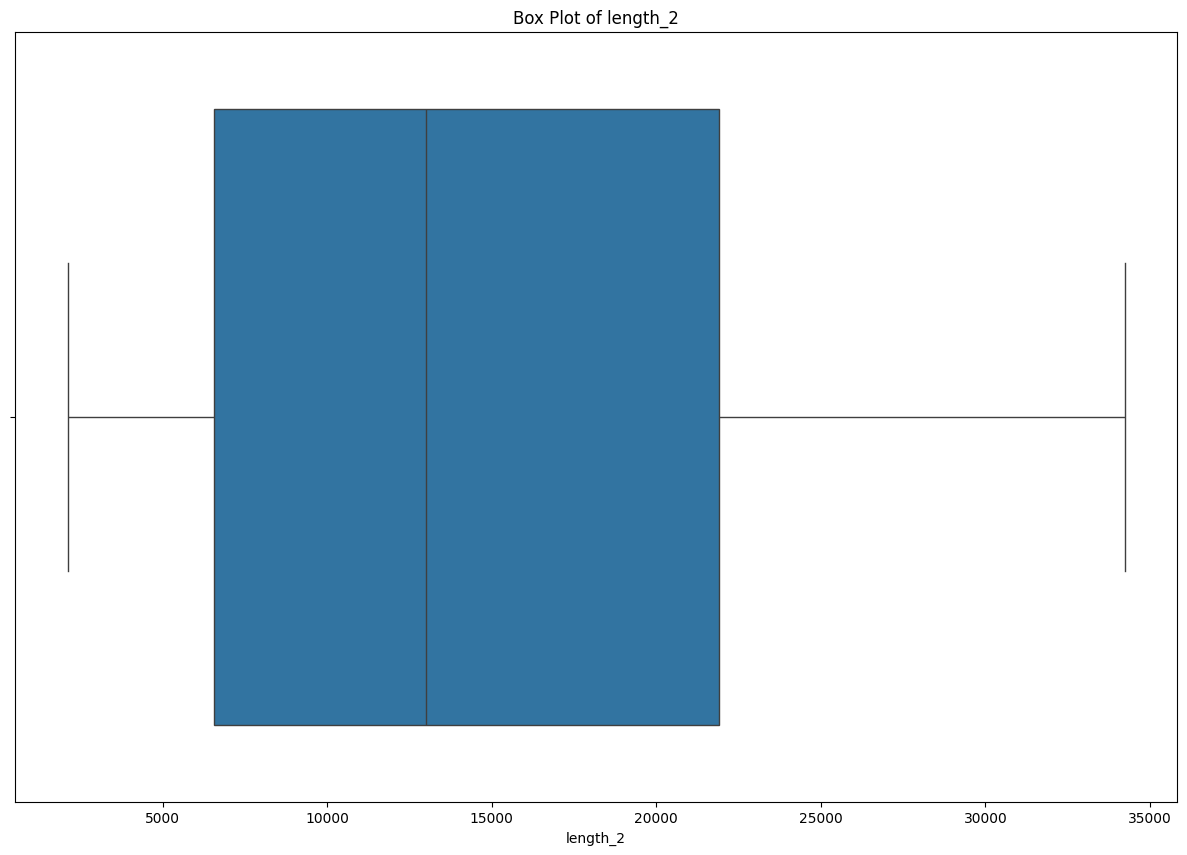

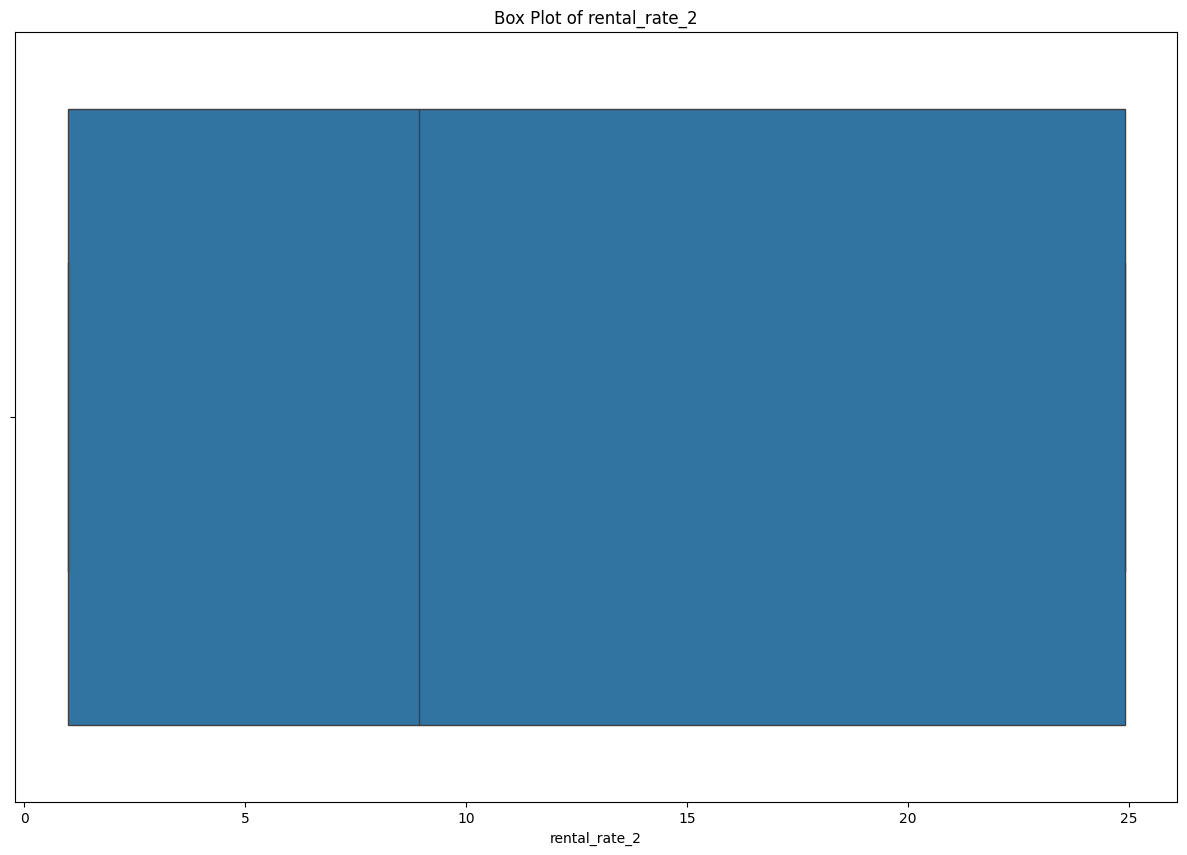

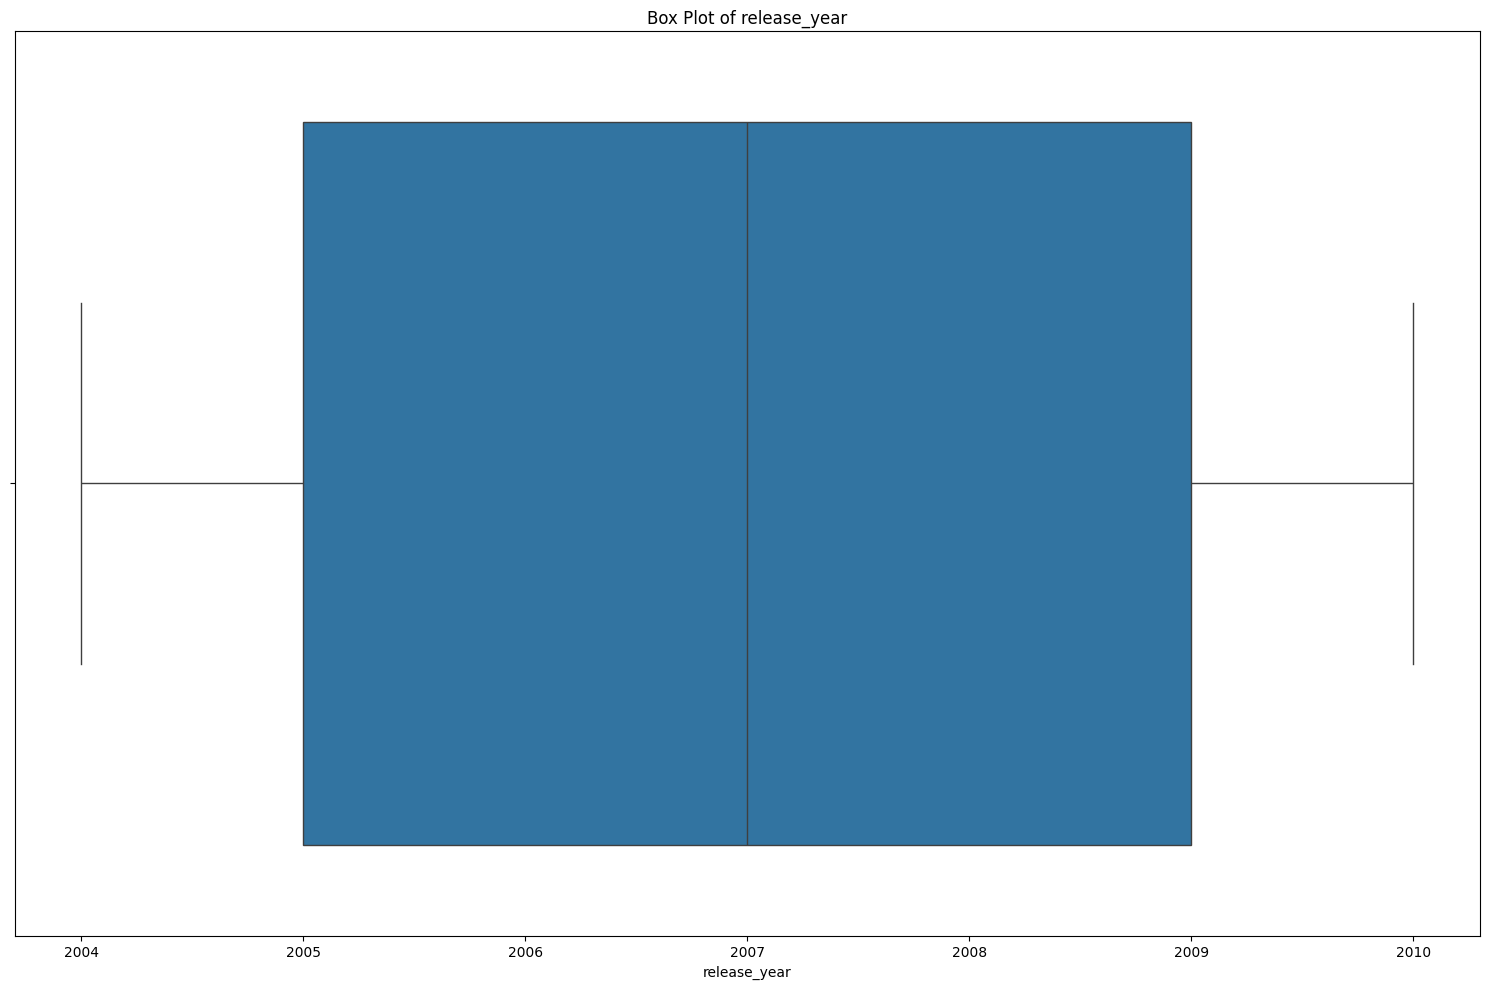

In [16]:
for i, feature in enumerate(numerical_features, 1):
    plt.figure(figsize=(15, 10))
    sns.boxplot(x=rental_df[feature])
    plt.title(f'Box Plot of {feature}')
    plt.xlabel(f'{feature}')
plt.tight_layout()
plt.show()

## Adding new dervied feature

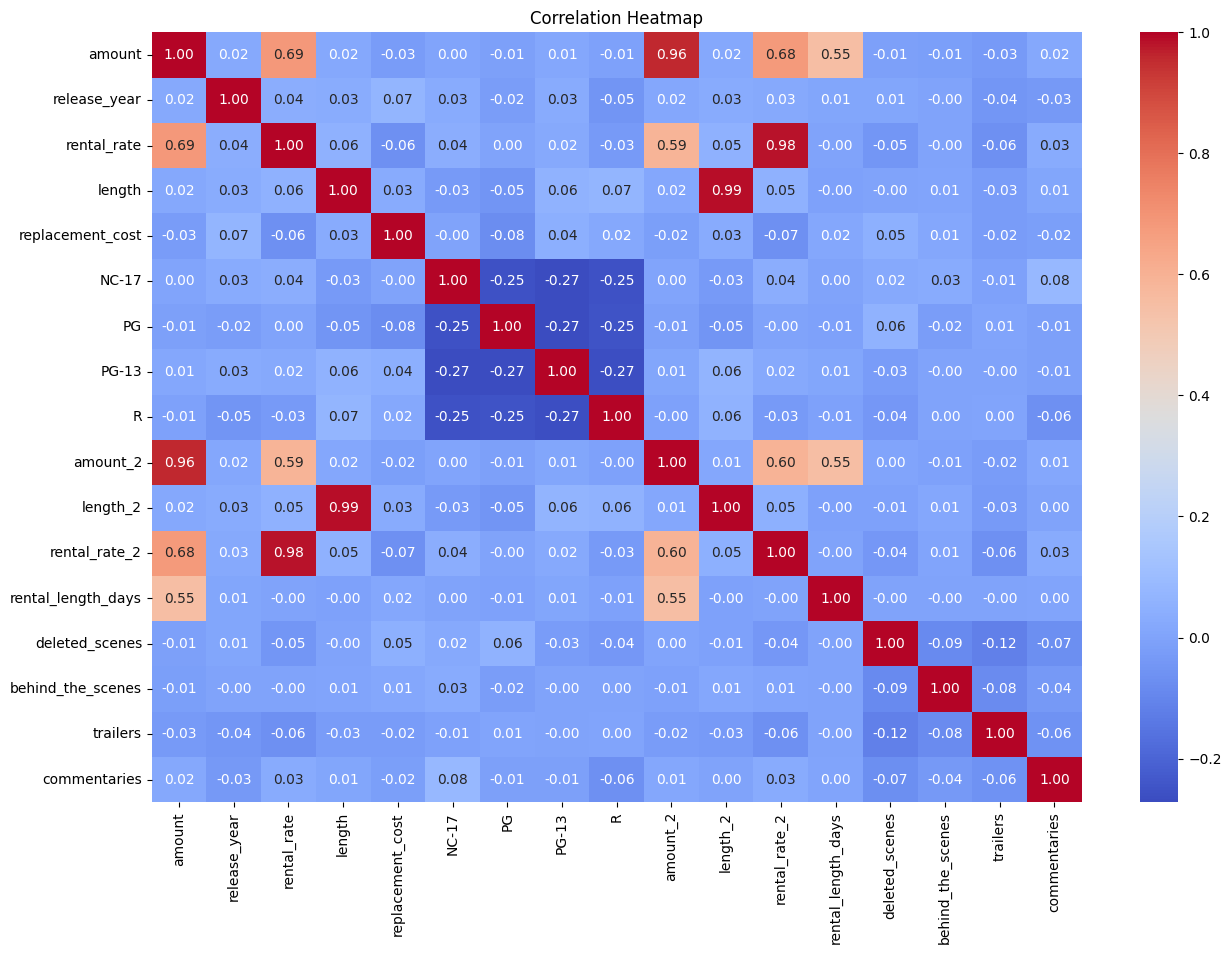

In [17]:
correlation_matrix = rental_df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Let's try to train RandomForest to get the feature importance

In [18]:
X = rental_df.drop(['rental_length_days'],axis=1)
y = rental_df ['rental_length_days']

X.shape,y.shape

((15861, 16), (15861,))

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=9)
rf.fit(X, y)

RandomForestRegressor(random_state=9)

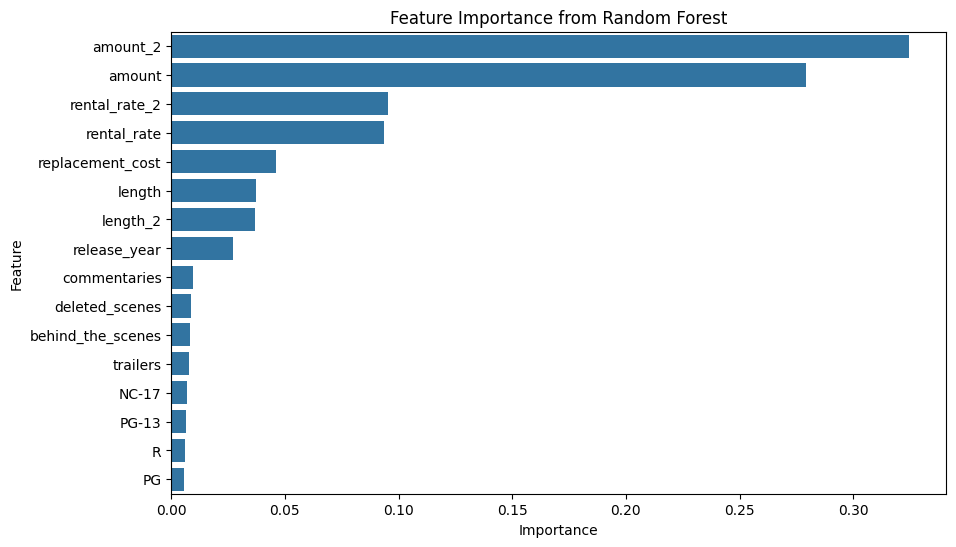

In [22]:
importances = rf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Forest')
plt.show()

**We can take all the numerical features in the prediction**

# Split the dataset and try several models

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [25]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [26]:
# models = {
#     "Linear Regression": LinearRegression(),
#     "Ridge Regression": Ridge(alpha=1.0, random_state=9),
#     "Lasso Regression": Lasso(alpha=0.01, random_state=9),
#     "Elastic Net": ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=9),
#     "Decision Tree": DecisionTreeRegressor(random_state=9),
#     "Random Forest": RandomForestRegressor(random_state=9),
#     "Gradient Boosting": GradientBoostingRegressor(random_state=9),
#     "XGBoost": XGBRegressor(random_state=9),
#     "CatBoost": CatBoostRegressor(random_state=9, verbose=0)
# }

# results = {}


# for name, model in models.items():

#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)

#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)

#     results[name] = {
#         "MSE": mse,
#         "R²": r2
#     }

In [27]:
# results_df = pd.DataFrame(results).T.sort_values(by='MSE')
# print(results_df)

## Let's try to tune hyperparameter of XGBoost

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

xgb = XGBRegressor(random_state=9, device='cuda')  # Use 'cuda' for GPU

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:12:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cuda',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=9, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 2, 4],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 0.9, 1.0],
                         'tree_method': ['gpu_hist']},
             scoring='neg_mean_squared_error', verbose=2)

In [30]:
grid_search.best_params_

{'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 200,
 'subsample': 0.8,
 'tree_method': 'gpu_hist'}

In [31]:
xgb_best = grid_search.best_estimator_

y_pred = xgb_best.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)

Mean Squared Error: 1.880340337753296


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:15:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:15:53] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
